In [1]:
#The code that inputs all videos and creates a CSV file of position of the hand

import cv2 as cv
import matplotlib.pyplot as plt
import csv
from csv import writer

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

inWidth = 368
inHeight = 368
inScale = 1

thr = 0.2

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

#Import image

#img = cv.imread("pose.png")
#plt.imshow(img)
#plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                               (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp)
    out = net.forward()

    assert (len(BODY_PARTS) <= out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert (partFrom in BODY_PARTS)
        assert (partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame



#estimated_image = pose_estimation(img)
#plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

#Video
vidcoordinates = []

vidvalue = []
vidnames=[]
namessubjects = ['Marcus','Andrei','Elsa','Nathalie','Oskar','Viktor']
for i in range(4):
    for j in namessubjects:
        for k in range(10):
            vidvalue.append(i)
            vidnames.append(f'Benpares {i} - {j} - {k+1}.mp4')
print(len(vidnames))

#vidnamess = ['Pares i arm right 3 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 2_Trim.mp4']
#vidnamess = ['nataliepeka1_1_20.mp4', 'nataliepeka1_4_20.mp4']
for i in vidnames:
    print(i)
    allpointsright =[]
    allpointsleft = []
    allpoints = []
    cap = cv.VideoCapture(i)
    cap.set(3, 800)
    cap.set(4, 800)

    if not cap.isOpened():
        cap = cv.VideoCapture(0)
    if not cap.isOpened():
        raise IOError('Cannot open video')
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            cv.waitKey()
            break
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                                   (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inp)
        out = net.forward()

        assert (len(BODY_PARTS) <= out.shape[1])

        points = []
        for i in range(len(BODY_PARTS)):
            # Slice heatmap of corresponding body's part.
            heatMap = out[0, i, :, :]

            # Originally, we try to find all the local maximums. To simplify a sample
            # we just find a global one. However only a single pose at the same time
            # could be detected this way.
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]

            # Add a point if it's confidence is higher than threshold.
            points.append((int(x), int(y)) if conf > thr else None)

        for pair in POSE_PAIRS:
            partFrom = pair[0]
            partTo = pair[1]
            assert (partFrom in BODY_PARTS)
            assert (partTo in BODY_PARTS)

            idFrom = BODY_PARTS[partFrom]
            idTo = BODY_PARTS[partTo]

            if points[idFrom] and points[idTo]:
                cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
                cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

        t, _ = net.getPerfProfile()
        freq = cv.getTickFrequency() / 2000
        cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
        #print(points)
        #cv.imshow('Pose estimation Tutorial', frame)
        
        if points[9] is not None:
            allpointsright.append(points[9][1]/1080)
        if points[12] is not None:
            allpointsleft.append(points[12][1]/1080)
    if min(allpointsright) < min(allpointsleft):
        #vidcoordinates.append(allpointsright)
        with open('vidcoordinates_openpose_pares_ben.csv', 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(allpointsright)
            f_object.close()
        print('right')
        print(allpointsright)
    elif min(allpointsright) > min(allpointsleft):
        #vidcoordinates.append(allpointsleft)
        with open('vidcoordinates_openpose_pares_ben.csv', 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(allpointsleft)
            f_object.close()
        print('left')
        print(allpointsleft)
    
#print(vidcoordinates)


240
Benpares 0 - Marcus - 1.mp4


KeyboardInterrupt: 

In [9]:
#From csv to list
#Börja med att köra denna när du har 'vidcoordinates.csv' i samma mapp som denna fil

import csv
import cv2 as cv
import matplotlib.pyplot as plt
import csv
from csv import writer

with open('vidcoordinates_openpose_pares_ben.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

newbetterlist = []
for i in data:
    if i:
        newbetterlist.append(i)
print(newbetterlist)

[['0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6518518518518519', '0.6296296296296297', '0.6518518518518519', '0.6518518518518519', '0.6518518518518519', '0.6518518518518519', '0.6518518518518519', '0.6518518518518519', '0.6518518518518519', '0.6296296296296297', '0.6518518518518519', '0.6518518518518519', '0.6296296296296297', '0.6296296296296297', '0.6083333333333333', '0.6083333333333333', '0.6083333333333333', '0.6083333333333333', '0.5861111111111111', '0.6083333333333333', '0.6083333333333333', '0.5861111111111111', '0.5861111111111111', '0.5861111111111111', '0.5648148148148148', '0.6083333333333333', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6296296296296297', '0.6518518518518519', '0.6296296296296297', '0.6731481481481482', '0.6518518518518519', '0.6518518518518519', '0.62962

In [10]:
vidvalue = []
namessubjects = ['Marcus','Andrei','Elsa','Nathalie','Oskar','Viktor']
for i in range(4):
    for j in namessubjects:
        for k in range(10):
                vidvalue.append(i)
print(vidvalue)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [11]:
vidcoordinates = newbetterlist

In [12]:
#Make strings into ints

for i in range(len(vidcoordinates)):
    for j in range(len(vidcoordinates[i])):
        vidcoordinates[i][j] = float(vidcoordinates[i][j])
print(vidcoordinates)

[[0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6518518518518519, 0.6296296296296297, 0.6518518518518519, 0.6518518518518519, 0.6518518518518519, 0.6518518518518519, 0.6518518518518519, 0.6518518518518519, 0.6518518518518519, 0.6296296296296297, 0.6518518518518519, 0.6518518518518519, 0.6296296296296297, 0.6296296296296297, 0.6083333333333333, 0.6083333333333333, 0.6083333333333333, 0.6083333333333333, 0.5861111111111111, 0.6083333333333333, 0.6083333333333333, 0.5861111111111111, 0.5861111111111111, 0.5861111111111111, 0.5648148148148148, 0.6083333333333333, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6296296296296297, 0.6518518518518519, 0.6296296296296297, 0.6731481481481482, 0.6518518518518519, 0.6518518518518519, 0.6296296296296297, 0.6083333333333333, 0.6296296296296297], [0.6953703703703704, 0.69537037037037

In [13]:
#Append zeros to make the same size
lengths = []
for i in vidcoordinates:
    lengths.append(len(i))
print(lengths)
print(max(lengths))

for i in vidcoordinates:
    while len(i) < max(lengths):
        i.append(0)
print(vidcoordinates)

[48, 48, 84, 83, 55, 59, 48, 55, 73, 55, 253, 259, 310, 308, 253, 335, 177, 199, 79, 220, 231, 335, 312, 286, 312, 287, 189, 275, 294, 208, 230, 1, 115, 279, 271, 276, 183, 141, 231, 197, 96, 294, 250, 237, 138, 279, 40, 118, 67, 224, 153, 263, 224, 182, 231, 277, 287, 279, 267, 359, 338, 341, 282, 257, 152, 108, 105, 129, 131, 282, 355, 322, 314, 295, 297, 293, 305, 1, 224, 261, 314, 314, 301, 287, 332, 229, 271, 253, 267, 239, 307, 232, 248, 246, 235, 264, 252, 275, 280, 169, 343, 248, 253, 282, 286, 223, 186, 338, 1, 258, 314, 269, 287, 268, 289, 218, 268, 280, 297, 171, 342, 331, 322, 334, 338, 214, 268, 164, 220, 294, 315, 303, 250, 313, 318, 246, 311, 294, 346, 253, 310, 308, 303, 303, 356, 268, 296, 266, 306, 259, 197, 251, 244, 254, 250, 1, 258, 260, 261, 209, 273, 267, 286, 254, 269, 1, 210, 182, 226, 393, 264, 236, 270, 271, 262, 251, 284, 276, 300, 391, 389, 390, 387, 409, 327, 337, 328, 338, 335, 329, 314, 335, 350, 322, 337, 292, 299, 296, 285, 343, 374, 380, 326, 357, 329

In [14]:
print(len(vidvalue), len(vidcoordinates))

240 240


In [32]:
print(vidcoordinates[169])

[0.5861111111111111, 0.5861111111111111, 0.5861111111111111, 0.5861111111111111, 0.5648148148148148, 0.5648148148148148, 0.5648148148148148, 0.5648148148148148, 0.5425925925925926, 0.5425925925925926, 0.5212962962962963, 0.5, 0.5, 0.4777777777777778, 0.4564814814814815, 0.43425925925925923, 0.412962962962963, 0.3907407407407407, 0.3472222222222222, 0.32592592592592595, 0.32592592592592595, 0.32592592592592595, 0.3037037037037037, 0.2824074074074074, 0.2824074074074074, 0.2601851851851852, 0.2388888888888889, 0.2388888888888889, 0.2388888888888889, 0.21666666666666667, 0.19537037037037036, 0.19537037037037036, 0.17314814814814813, 0.17314814814814813, 0.17314814814814813, 0.17314814814814813, 0.15185185185185185, 0.15185185185185185, 0.15185185185185185, 0.15185185185185185, 0.15185185185185185, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.12962962962962962, 0.129

0


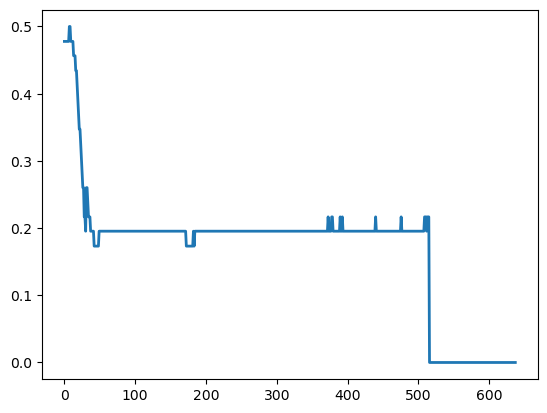

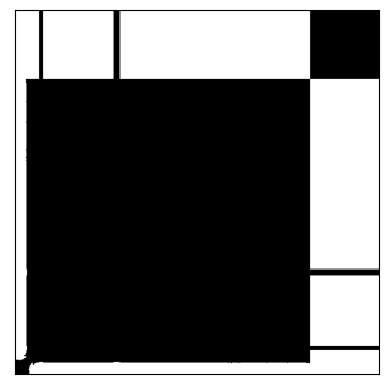

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from pyts.image import RecurrencePlot

y = np.linspace(0,637,637)

# Create a toy time series using the sine function
time_points = np.linspace(0, 4 * np.pi, 1000)
x = np.sin(time_points)

a = 20

x = vidcoordinates[a]

print(vidvalue[a])

X = np.array([x])

plt.plot(y, x, linewidth=2.0)

# Recurrence plot transformation
rp = RecurrencePlot(threshold=np.pi/18)
X_rp = rp.transform(X)

# Plot the time series and its recurrence plot
fig = plt.figure(figsize=(6, 6))


# Plot the recurrence plot on the bottom right
ax_rp = fig.add_subplot(gs[1, 1])
ax_rp.imshow(X_rp[0], cmap='binary', origin='lower',
             extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_rp.set_xticks([])
ax_rp.set_yticks([])

plt.show()

In [15]:
#Denna cell är själva neurala nätverket, så lägg in en till cell under som tar samma input men med annan ML-algoritm

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

import numpy as np

y = np.array(vidvalue)
X = np.array(vidcoordinates)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
#X_train, X_test = X_train / 1080.0, X_test / 1080.0
print(X_train)
print(y_train)
#Gammalt

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)


model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train, y_train,
           batch_size=25,
           epochs=5,
           verbose=1,
           validation_data=(X_test, y_test))

model.evaluate(X_test, y_test)

[[0.62962963 0.62962963 0.62962963 ... 0.         0.         0.        ]
 [0.67314815 0.67314815 0.67314815 ... 0.         0.         0.        ]
 [0.60833333 0.60833333 0.62962963 ... 0.         0.         0.        ]
 ...
 [0.62962963 0.62962963 0.62962963 ... 0.         0.         0.        ]
 [0.58611111 0.58611111 0.60833333 ... 0.         0.         0.        ]
 [0.62962963 0.62962963 0.62962963 ... 0.         0.         0.        ]]
[1 2 2 1 1 1 1 1 1 3 2 1 0 2 1 1 0 0 2 2 1 1 3 3 2 0 0 0 0 0 3 2 2 0 2 3 1
 0 2 2 1 2 0 3 3 3 2 0 0 1 0 1 1 2 2 1 1 2 2 1 0 2 1 0 1 2 3 0 0 3 0 2 0 2
 0 2 2 1 2 2 3 3 1 3 1 0 2 0 2 0 2 3 1 0 3 0 1 3 0 2 3 0 1 0 2 3 3 3 0 2 1
 0 0 2 1 1 1 3 3 1 0 0 0 3 2 0 2 1 3 2 3 3 1 0 1 0 3 2 3 3 3 3 2 0 0 1 0 0
 3 2 3 3 3 2 0 2 3 0 0 2 2 2 1 1 1 1 3 1 3 3 2 3 0 3 1 1 0 1 2 1]
Epoch 1/5
8/8 [==============================] - 3s 92ms/step - loss: 1.4492 - accuracy: 0.2722 - val_loss: 1.2071 - val_accuracy: 0.4500
Epoch 2/5
8/8 [==============================] - 0s 

[1.1696804761886597, 0.46666666865348816]

In [17]:
tf.shape(X_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([128, 637])>